In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import random
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# **TRIPLET LOSS MODEL ON MNIST**

Class TripletMnist that prepares data from MNIST, returns a triplet of images with labels.

In [4]:
class TripletMnist(Dataset):
    def __init__(self):
        super().__init__()
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081))])
        self.mnist = datasets.MNIST(root='data', train=True, transform=transform, download=True)
        
        self.data_by_label = {}
        for idx, (image, label) in enumerate(self.mnist):
            if label not in self.data_by_label:
                self.data_by_label[label] = []
            self.data_by_label[label].append(idx)
    
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx):
        anchor_img, anchor_label = self.mnist[idx]
        
        positive_idx = idx
        while positive_idx == idx:  #preventing from selecting the same image
            positive_idx = random.choice(self.data_by_label[anchor_label])
        positive_img, _ = self.mnist[positive_idx]
        
        negative_label = anchor_label
        while negative_label == anchor_label:
            negative_label = random.choice(list(self.data_by_label.keys()))
        negative_idx = random.choice(self.data_by_label[negative_label])
        negative_img, _ = self.mnist[negative_idx]
        
        return (anchor_img, positive_img, negative_img), (anchor_label, anchor_label, negative_label)

# Simple Convolutional Neural Network

This is a simple CNN used to extract features from images. It consists of 2 convolutional layers (pooled), 2 fully connected layers, ending with embedding vector normalization.

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5) 
        self.fc1 = nn.Linear(64 * 4 * 4, 256) 
        self.fc2 = nn.Linear(256, 64)  # Embedding size = 64
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)  # 64 elementowy wektor
        return F.normalize(x, p=2, dim=1) 

### Model hyperparameters

In [6]:
learning_rate = 0.001
margin_triplet_loss = 1.0
num_epochs = 2
batch_size = 64

### Initialization of the model, optimizer and triplet loss.

I used the Adam optimizer.
Adam Optimizer [Adaptive Moment Estimation] is an algorithm for optimization technique for gradient descent.

In [7]:
model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
triplet_loss_fn = nn.TripletMarginLoss(margin=margin_triplet_loss, p=2)

DATA LOADING

In [8]:
train_dataset = TripletMnist()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw


## TRIPLET VISUALIZATION

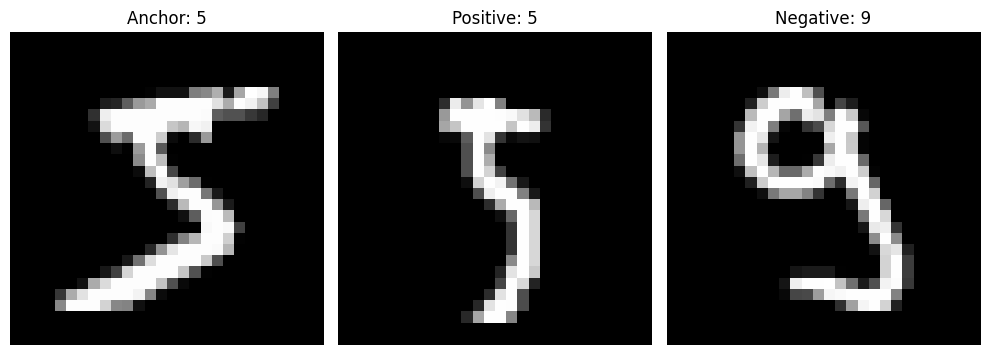

In [9]:
def visualize_triplet(dataset, index):
    (anchor_img, positive_img, negative_img), (anchor_label, positive_label, negative_label) = dataset[index]

    # Converting images to NumPy (values  0-255)
    anchor_img = anchor_img.squeeze().numpy() * 255
    positive_img = positive_img.squeeze().numpy() * 255
    negative_img = negative_img.squeeze().numpy() * 255

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(anchor_img, cmap='gray')
    plt.title(f'Anchor: {anchor_label}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(positive_img, cmap='gray')
    plt.title(f'Positive: {positive_label}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(negative_img, cmap='gray')
    plt.title(f'Negative: {negative_label}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_triplet(train_dataset, index=0)

COMPUTING DEVICE

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
)

## Trenowanie modelu

In [11]:
for epoch in range(num_epochs):
    print(f"Epoch no. {epoch}")
    model.train() 
    total_loss = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f'Batch index: {batch_idx}')
        anchor, positive, negative = images
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        # Anchor, positive, negative embeddings
        anchor_embed = model(anchor)
        positive_embed = model(positive)
        negative_embed = model(negative)
        
        #Triplet Loss
        loss = triplet_loss_fn(anchor_embed, positive_embed, negative_embed)
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() #parameters update 
        
        total_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Loss: {total_loss/len(train_loader):.3f}")

Epoch no. 0
Batch index: 0
Batch index: 1
Batch index: 2
Batch index: 3
Batch index: 4
Batch index: 5
Batch index: 6
Batch index: 7
Batch index: 8
Batch index: 9
Batch index: 10
Batch index: 11
Batch index: 12
Batch index: 13
Batch index: 14
Batch index: 15
Batch index: 16
Batch index: 17
Batch index: 18
Batch index: 19
Batch index: 20
Batch index: 21
Batch index: 22
Batch index: 23
Batch index: 24
Batch index: 25
Batch index: 26
Batch index: 27
Batch index: 28
Batch index: 29
Batch index: 30
Batch index: 31
Batch index: 32
Batch index: 33
Batch index: 34
Batch index: 35
Batch index: 36
Batch index: 37
Batch index: 38
Batch index: 39
Batch index: 40
Batch index: 41
Batch index: 42
Batch index: 43
Batch index: 44
Batch index: 45
Batch index: 46
Batch index: 47
Batch index: 48
Batch index: 49
Batch index: 50
Batch index: 51
Batch index: 52
Batch index: 53
Batch index: 54
Batch index: 55
Batch index: 56
Batch index: 57
Batch index: 58
Batch index: 59
Batch index: 60
Batch index: 61
Batch 

# Embeddings visualization
The visualize_embeddings function reduces the dimensionality of embeddings and observe class separation.

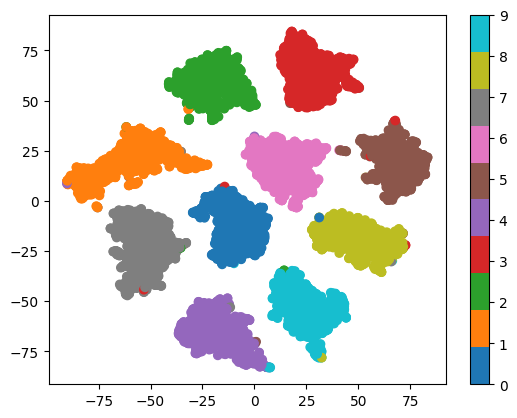

In [12]:
def visualize_embeddings(model, dataset, num_samples=10000):
    model.eval()
    
    embeddings = []
    labels = []
    
    for i in range(num_samples):
        
        (anchor_img, positive_img, negative_img), (anchor_label, positive_label, negative_label) = dataset[i]
        
        img = anchor_img.unsqueeze(0).to(device)  # adding batch dimension
        embedding = model(img).detach().cpu().numpy() #data to CPU
        
        embeddings.append(embedding)
        labels.append(anchor_label)
    
    embeddings = np.concatenate(embeddings, axis=0) # [[...],[...],[...]
    
    # Reduction of dimension to 2D
    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings)
    

    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.show()

visualize_embeddings(model, train_dataset)